In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

import ipywidgets as widgets
from ipywidgets import GridBox, Button
from IPython.display import display, clear_output

import os
from datetime import datetime

C:\Users\power\AppData\Local\Temp\ipykernel_26784\1987386995.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Read progress and records files

In [2]:
environments = {
    "water_tank": {
        "base_dir": "../logs/ppo/double_water_tank/trainings",
        "tracked_point": "x2",
    },
    "CPAP": {
        "base_dir": "../logs/ppo/CPAP",
        "tracked_point": "x3",
    },
}


env = environments["water_tank"]
base_dir = env["base_dir"]
tracked_point = env["tracked_point"]

index = None # -1
folder_names = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))][:index]
def folder_to_datetime(folder_name):
    """
    Função para converter o nome da pasta em um objeto datetime.
    Combinada com max(), é possível ordenar de forma decrescente pastas por data da mais recente (max) para antiga (min).
    O nome da pasta DEVE estar no formato '%d-%m-%H%M' ou ter uma substring nesse formato para funcionar corretamente.
    """
    pattern = r'\d{2}-\d{2}-\d{4}'
    match = re.search(pattern, folder_name)
    if match:
        date_str = match.group(0)
        date_str = datetime.strptime(date_str, '%d-%m-%H%M')
        return (date_str.month, date_str.day)
    else:
        raise ValueError(f"Formato de data inválido na pasta: {folder_name}")


folder_names.sort(key=folder_to_datetime)

latest_folder = folder_names[-1] # max(folder_names, key=folder_to_datetime)
selected_folder = latest_folder
selected_index = len(folder_names) - 1


# print(folder_names)
# print(f"A pasta mais recente é: {latest_folder}")

In [3]:
def are_required_files_present(folder: str):
    return all([
        os.path.exists(f"{base_dir}/{folder}/progress.csv"),
        os.path.exists(f"{base_dir}/{folder}/records.csv"),
        # os.path.exists(f"{base_dir}/{folder}/only_pid_records.csv"),
    ])

In [4]:
def load_dfs(folder: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    if not are_required_files_present(folder):
        raise FileNotFoundError("Arquivos necessários não encontrados.")
    
    progress_df = pd.read_csv(f"{base_dir}/{folder}/progress.csv")
    rec_df = pd.read_csv(f"{base_dir}/{folder}/records.csv")

    # Find the index of the last episode start
    mask = rec_df["steps_in_episode"] == 1
    start_episode_indexes = mask[mask].index.to_list()
    last_episode_start_idx = start_episode_indexes[-1]

    # Filter the dataframe for the last episode
    last_episode_df = rec_df.loc[last_episode_start_idx:]

    return progress_df, rec_df, last_episode_df

progress_df, rec_df, last_episode_df = load_dfs(latest_folder)

In [5]:
progress_df.head()

,train/value_loss,train/loss,train/std,train/learning_rate,train/n_updates,train/entropy_loss,train/clip_range,train/iteration,train/explained_variance,train/policy_gradient_loss,train/clip_fraction,train/approx_kl
0,0.000002,-0.060568,5.0,0.0001,20000,-3.028377,0.2,8,NaN,0.0,0.502,0.196938


In [6]:
rec_df

,x1,x2,y_ref,z_t,PID_action,PPO_action,combined_action,reward,error,steps_in_episode
0,0.000000,5.000000,3.0,0.000000,0,-10.000000,-10.000000,-2.572233,-1.603818,1
1,0.000000,4.603818,3.0,-1.603818,0,-10.000000,-10.000000,-1.497335,-1.223656,2
2,0.000000,4.223656,3.0,-2.827475,0,-10.000000,-10.000000,-0.738789,-0.859529,3
3,0.000000,3.859529,3.0,-3.687003,0,-2.790552,-2.790552,-0.261582,-0.511451,4
4,0.000000,3.511451,3.0,-4.198454,0,-4.900019,-4.900019,-0.032198,-0.179439,5
...,...,...,...,...,...,...,...,...,...,...
399995,2.846916,1.975765,2.0,-24.162054,0,0.712415,0.712415,-0.000659,-0.025670,1996
399996,2.690450,2.025670,2.0,-24.187725,0,-6.439490,-6.439490,-0.004111,-0.064117,1997
399997,2.399833,2.064117,2.0,-24.251841,0,-5.749015,-5.749015,-0.007062,-0.084038,1998
399998,2.125360,2.084038,2.0,-24.335880,0,-10.000000,-10.000000,-0.007493,-0.086561,1999


# Separa as linhas por episódio

In [7]:
mask = rec_df["steps_in_episode"] == 1
start_episode_indexes = mask[mask].index.to_list()

first_episode_start = start_episode_indexes[0]
first_episode_end = start_episode_indexes[1] - 1 if len(start_episode_indexes) > 1 else len(rec_df) - 1

last_episode_start = start_episode_indexes[-1]
last_episode_end = len(rec_df) - 1

first_episode = rec_df.iloc[first_episode_start:first_episode_end+1]
last_episode = rec_df.iloc[last_episode_start:last_episode_end+1]

episodes_count = len(start_episode_indexes)

In [8]:
first_episode

,x1,x2,y_ref,z_t,PID_action,PPO_action,combined_action,reward,error,steps_in_episode
0,0.000000,5.000000,3.0,0.000000,0,-10.000000,-10.000000,-2.572233,-1.603818,1
1,0.000000,4.603818,3.0,-1.603818,0,-10.000000,-10.000000,-1.497335,-1.223656,2
2,0.000000,4.223656,3.0,-2.827475,0,-10.000000,-10.000000,-0.738789,-0.859529,3
3,0.000000,3.859529,3.0,-3.687003,0,-2.790552,-2.790552,-0.261582,-0.511451,4
4,0.000000,3.511451,3.0,-4.198454,0,-4.900019,-4.900019,-0.032198,-0.179439,5
...,...,...,...,...,...,...,...,...,...,...
1995,2.642076,2.174507,2.0,-24.607327,0,2.157156,2.157156,-0.040493,-0.201230,1996
1996,2.785515,2.201230,2.0,-24.808558,0,-6.176467,-6.176467,-0.054787,-0.234066,1997
1997,2.489807,2.234066,2.0,-25.000000,0,-8.198110,-8.198110,-0.061908,-0.248813,1998
1998,2.210236,2.248813,2.0,-25.000000,0,-1.284622,-1.284622,-0.060774,-0.246525,1999


In [9]:
last_episode

,x1,x2,y_ref,z_t,PID_action,PPO_action,combined_action,reward,error,steps_in_episode
398000,0.000000,5.000000,3.0,0.000000,0,-10.000000,-10.000000,-2.572233,-1.603818,1
398001,0.000000,4.603818,3.0,-1.603818,0,-10.000000,-10.000000,-1.497335,-1.223656,2
398002,0.000000,4.223656,3.0,-2.827475,0,-10.000000,-10.000000,-0.738789,-0.859529,3
398003,0.000000,3.859529,3.0,-3.687003,0,-8.130672,-8.130672,-0.261582,-0.511451,4
398004,0.000000,3.511451,3.0,-4.198454,0,-7.684743,-7.684743,-0.032198,-0.179439,5
...,...,...,...,...,...,...,...,...,...,...
399995,2.846916,1.975765,2.0,-24.162054,0,0.712415,0.712415,-0.000659,-0.025670,1996
399996,2.690450,2.025670,2.0,-24.187725,0,-6.439490,-6.439490,-0.004111,-0.064117,1997
399997,2.399833,2.064117,2.0,-24.251841,0,-5.749015,-5.749015,-0.007062,-0.084038,1998
399998,2.125360,2.084038,2.0,-24.335880,0,-10.000000,-10.000000,-0.007493,-0.086561,1999


### Plot Train over iteraçtion

In [10]:
def plot_progress(folder: str, save = False):
    # Plotting train/loss vs train/iteration
    plt.figure(figsize=(12, 6))
    plt.plot(progress_df['train/iteration'], progress_df['train/loss'], label='Train Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Iteration')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/loss_over_iteration.png")
    plt.show()

# plot_progress(latest_folder, save = True)

### Plote reward over steps

In [11]:
def plot_rewards(folder: str, save=False):
    # Plotting reward vs steps
    plt.figure(figsize=(12, 6))
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df['reward'], label='Reward')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.title('Reward vs. Steps')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/reward_over_last_episode_steps.png")
    plt.show()

# plot_rewards(latest_folder, save=True)

### Plot Set point curve

In [12]:
def plot_tracking(folder: str, save: bool = False):
    # Plot y_ref vs steps_in_episode
    plt.figure(figsize=(12, 6))
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df[tracked_point], label="Altura da água no segundo tanque", color='red')
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df['y_ref'], '--', label='y_ref (Objetivo)', color='black')
    plt.xlabel('Steps')
    plt.ylabel('')
    plt.title('Altura da água no segundo tanque em cada passo no último episódio')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/tracking.png")
    plt.show()

# plot_tracking(latest_folder, save=True)

### Ação do PPO e PID durante o último episódio

In [13]:
def plot_action_per_steps(folder: str, save: bool = False, separeted: bool = True):

    if (separeted):
        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PID_action'], label='PID_action', color='blue')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação do controlador PID em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/PID_action.png")
        plt.show()

        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PPO_action'], label='PPO_action', color='red')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação do controlador PPO em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/PPO_action.png")
        plt.show()
    else:
        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PID_action'], label='PID_action', color='blue')
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PPO_action'], label='PPO_action', color='red')
        # plt.plot(last_episode_df['steps_in_episode'], last_episode_df['action'], label='Action', color='black')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/combined_action.png")
        plt.show()

# plot_action_per_steps(latest_folder, save=True)

# Função para exibir a grade de pastas

In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def display_folders_grid(folder_names: list[str], selected_indices: int = 0) -> widgets.VBox:
    num_cols = 5
    previous_selected = [selected_indices]
    
    def on_button_click(b: widgets.Button):
        global selected_folder
        selected_folder = b.description

        global progress_df, rec_df, last_episode_df
        progress_df, rec_df, last_episode_df = load_dfs(selected_folder)

        previous_selected.append(buttons.index(b))
        if len(previous_selected) > 2:
            previous_selected.pop(0)
        
        # Atualiza cor dos botões
        buttons[previous_selected[0]].button_style = '' 
        buttons[previous_selected[1]].button_style = 'success'

        clear_output(wait=True)  # Limpar as saídas anteriores
        display(grid)            # Reexibir a grade de botões
        display(save_button)     # Reexibir o botão de salvar

        plot_tracking(selected_folder, save=False)
        plot_rewards(selected_folder, save=False)
        plot_action_per_steps(selected_folder, save=False)

    def on_save_click(b: widgets.Button):
        should_save = True  # Ativar o modo de salvar
        
        if 'selected_folder' in globals():
            plot_tracking(selected_folder, save=should_save)
            plot_rewards(selected_folder, save=should_save)
            plot_action_per_steps(selected_folder, save=should_save)
            print(f"Plots salvos para {selected_folder}!")
        else:
            print("Nenhuma pasta selecionada ainda!")

    # Criar os botões para as pastas
    buttons = []
    for i, folder in enumerate(folder_names):
        button = widgets.Button(description=folder, layout=widgets.Layout(width='auto', height='auto'))
        button.on_click(on_button_click)
        buttons.append(button)
    
    # Marcar o primeiro botão como ativo
    buttons[selected_indices].button_style = 'success'  
    
    # Criar o botão de salvar
    save_button = widgets.Button(description="Salvar Gráficos", button_style='info')
    save_button.on_click(on_save_click)

    # Criar a grade de botões
    grid = widgets.GridBox(
        children=buttons,
        layout=widgets.Layout(grid_template_columns=f'repeat({num_cols}, 1fr)')
    )

    display(save_button)
    display(grid)
    display(save_button)


GridBox(children=(Button(description='11-02-2111', layout=Layout(height='auto', width='auto'), style=ButtonSty…

Button(button_style='info', description='Salvar Gráficos', style=ButtonStyle())

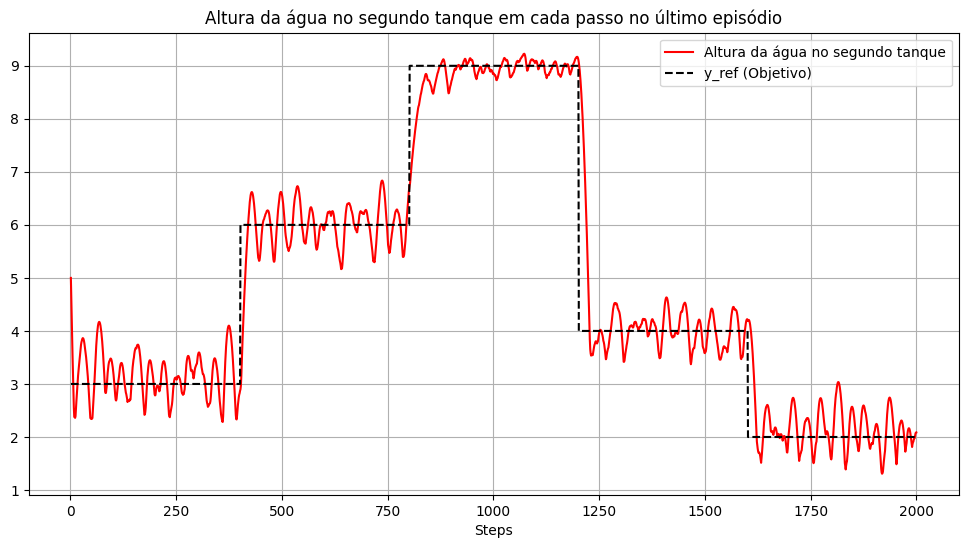

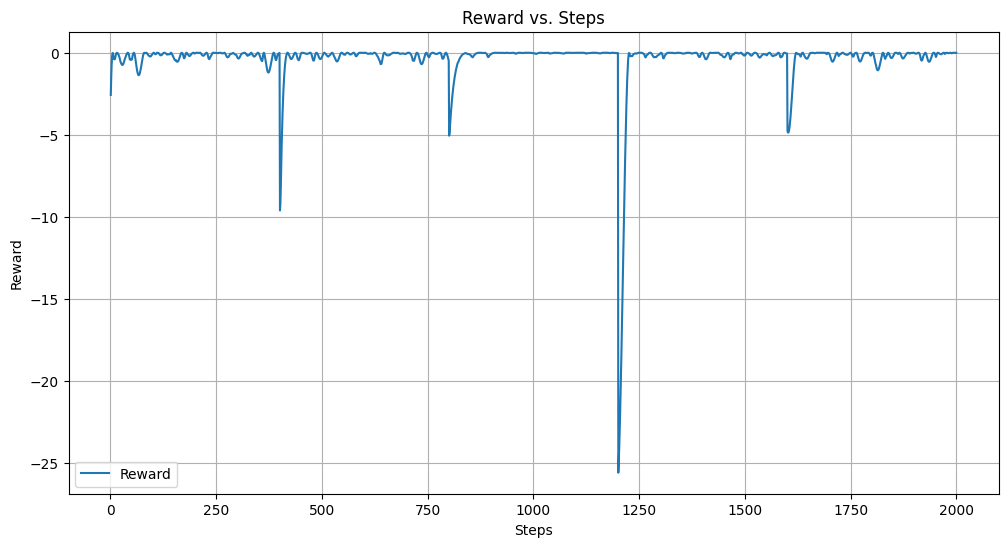

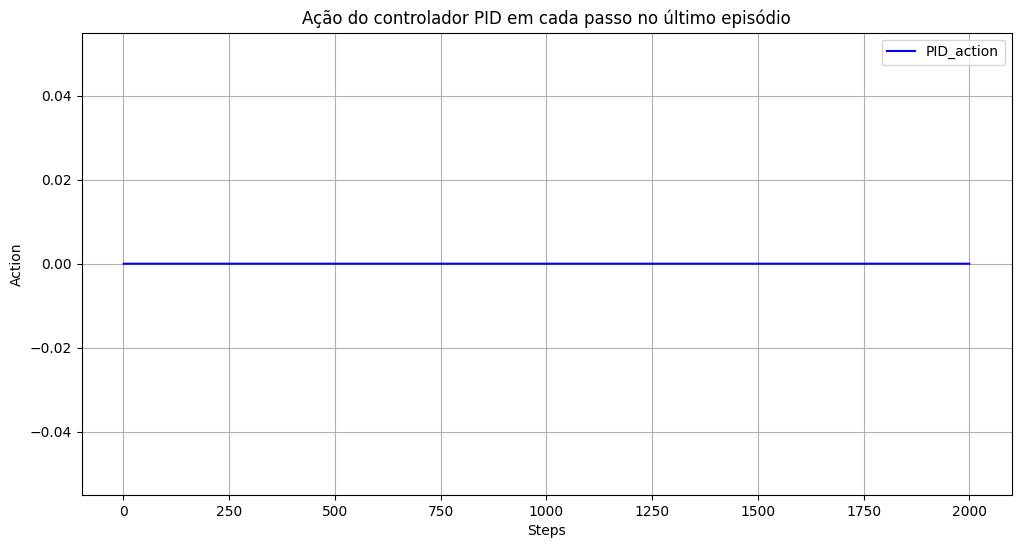

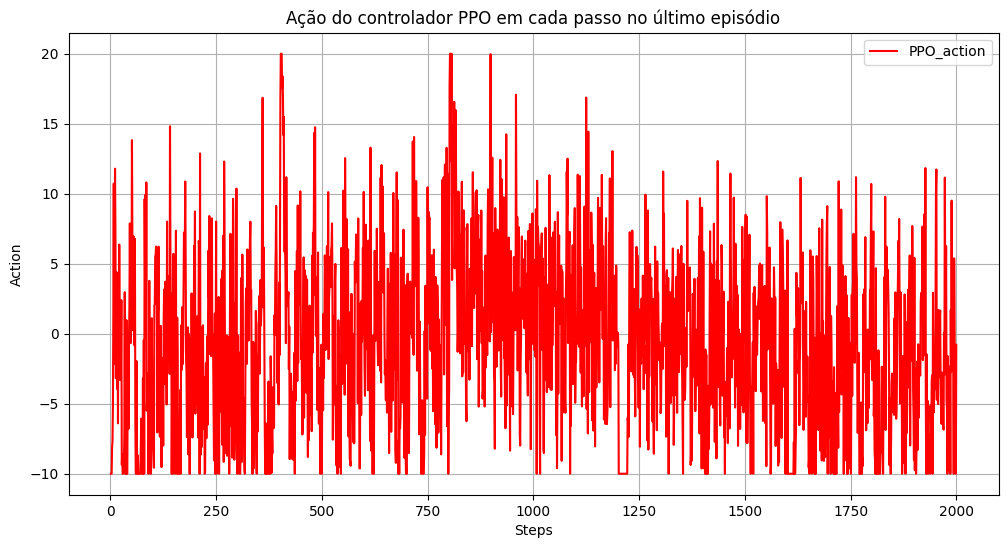

In [15]:
# Uncomment to use widget 
display_folders_grid(folder_names, selected_index)